In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
filepath='./../data/train_clean.csv'
df=pd.read_csv(filepath)

<p style="font-size:25px">In this notebook, I will be exploring the data for this project. </p>
</br>
<p style="font-size:16px;">Our end goal is to predict the value of houses in Ames, Iowas. With that goal in mind, lets start by looking at the distribution of the home prices.</p>

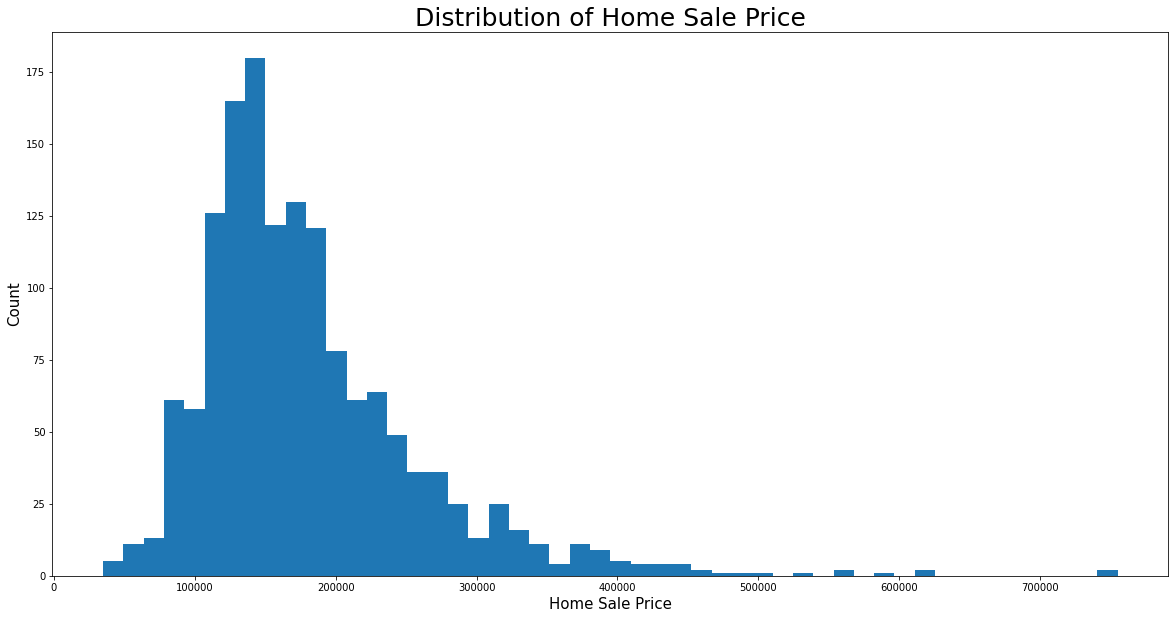

In [2]:
plt.figure(figsize=(20,10))
plt.xlabel('Home Sale Price',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title("Distribution of Home Sale Price",fontsize=25)
temp=plt.hist(df['SalePrice'],bins=50)

<p style="font-size:16px;">There is a heavy right skew in the distribution of home prices. This skew presents a problem for two main reasons:</p>
<ol>
    <li>The extreme outliers have the potential to lower model performance because some models aren't robust to outliers.</li>
    <dd style="font-size:12px"><i>(I could use a logorithmic transformation to help with the skew but it is better to drop the outliers for this project. I explain why with my second reason)</i></dd>
    <li>Because more expensive homes exist in small quantities, that makes them a niche market. I wish for my model to be used for the average home because that is what is most popular. By dropping the outliers, the model is able to be more specialized to cater to houses that are in demand.</li>
</ol>

<p style="font-size:20px">Qualitative Analysis</p>
</br>
<p>For the sake of brevity, I will discuss the general trends in the relationships between the numeric variables and the home price that are worth mentioning. There is a strong relationship between the value of home with its age and size. The graphs below do a great job of showing this.</p>
</br>
<p style="font-size:12px"><i><b>Note:</b> When I say "size", I'm referring to variables that measure some spatial aspect of the house such as total square footage. When I say "age", I'm referring to variables that measure some temporal aspect of the house such as the year the house was built.</i></p>



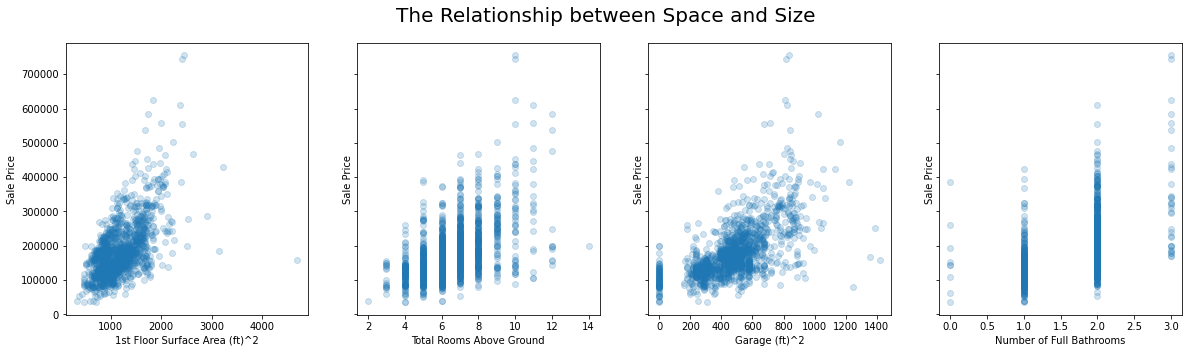

In [3]:
cols=['1stFlrSF','TotRmsAbvGrd','GarageArea','FullBath']
f, ax = plt.subplots(1, 4, sharey=True,figsize=(20,5))
f.suptitle('The Relationship between Space and Size',fontsize=20)
titles=['1st Floor Surface Area (ft)^2', 'Total Rooms Above Ground','Garage (ft)^2','Number of Full Bathrooms']
i=0
for col in cols:
    ax[i].set_xlabel(titles[i])
    ax[i].set_ylabel('Sale Price')
    ax[i].scatter(df[col],df['SalePrice'],alpha=0.2)
    i+=1

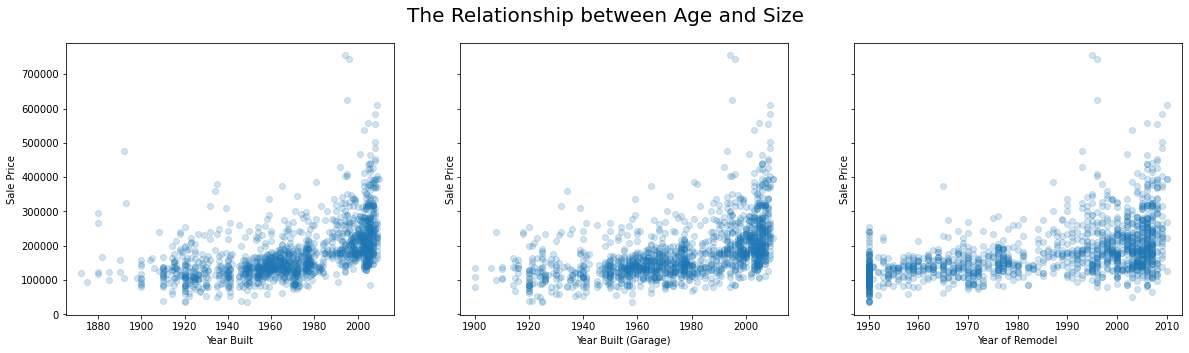

In [4]:
cols=['YearBuilt','GarageYrBlt','YearRemodAdd']
f, ax = plt.subplots(1, 3, sharey=True,figsize=(20,5))
f.suptitle('The Relationship between Age and Size',fontsize=20)
titles=['Year Built', 'Year Built (Garage)','Year of Remodel']
i=0
for col in cols:
    ax[i].set_xlabel(titles[i])
    ax[i].set_ylabel('Sale Price')
    ax[i].scatter(df[col],df['SalePrice'],alpha=0.2)
    i+=1

From these graphs we can see that as size increase, home price increases. When it comes to age and price, the inverse is true. As age decreases, price increases. Furthermore, size seems to have more of an impact on price than age.

Another trend that I noticed in the data was the occurance of inflential points. These points are a special kind of outlier that hurt model performance so I used Cook's Distance to find them. I will remove them in the feature engineering phase.

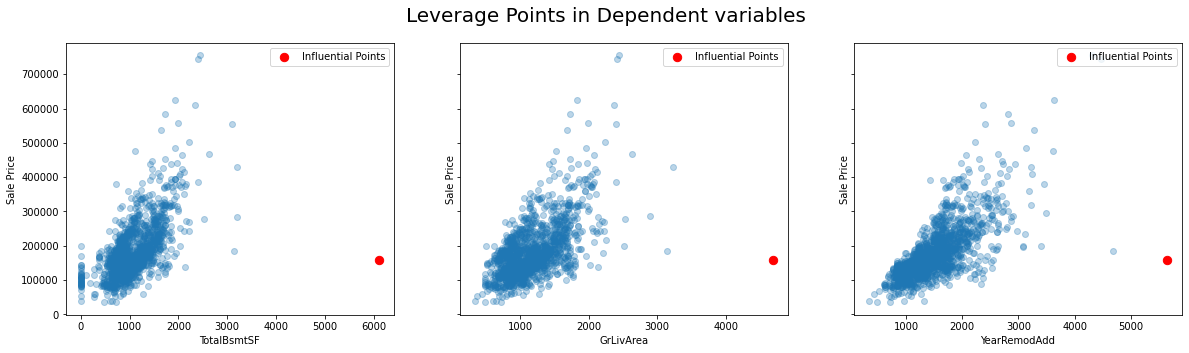

In [5]:
temp=df.corr()
temp=temp[temp['SalePrice']>.5]
temp['SalePrice'].index[:-1]
f, ax = plt.subplots(1, 3, sharey=True,figsize=(20,5))
f.suptitle('Leverage Points in Dependent variables',fontsize=20)
titles=['TotalBsmtSF', 'GrLivArea','YearRemodAdd']
i=0

for col in temp['SalePrice'].index[:-1]:
    x=df[col]
    y=df['SalePrice']
    
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()

    np.set_printoptions(suppress=True)

    #create instance of influence
    influence = model.get_influence()

    #obtain Cook's distance for each observation
    cooks = influence.cooks_distance

    temp=pd.DataFrame([df[col],df['SalePrice'],cooks[0]]).T
    temp.columns=[col,'SalePrice','c.d.']
    temp=temp[temp['c.d.']>0.5]
    if temp.shape[0]!=0:
        ax[i].set_xlabel(titles[i])
        ax[i].set_ylabel('Sale Price')
        ax[i].scatter(df[col],df['SalePrice'],alpha=0.3)
        ax[i].scatter(temp[col],temp['SalePrice'],color="red",s=70,label='Influential Points')
        ax[i].legend(loc=1)
        i+=1     

The red points in the graphs above indicate the influential points which hurt model performance.

<p style="font-size:20px">Quantitative Analysis</p>
</br>
<p>In this section, Im looking at the quantitative variables and their relationship with the home price. Below is only a preview of the quantitative variables for the sake of brevity.</p>

In [6]:
temp=[i for i in df.columns if i not in df.corr().columns]
temp=df[temp]
temp=temp.describe().T
temp['freq (as a percentage)']=temp['freq']/temp['count']
temp.head(10)

,count,unique,top,freq,freq (as a percentage)
MSZoning,1460,5,RL,1151,0.788356
Street,1460,2,Pave,1454,0.99589
LotShape,1460,4,Reg,925,0.633562
LandContour,1460,4,Lvl,1311,0.897945
Utilities,1460,2,AllPub,1459,0.999315
LotConfig,1460,5,Inside,1052,0.720548
LandSlope,1460,3,Gtl,1382,0.946575
Neighborhood,1460,25,NAmes,225,0.15411
Condition1,1460,9,Norm,1260,0.863014
Condition2,1460,8,Norm,1445,0.989726


A significant number of variables are heavily imbalanced. For example, in the "Street" column, 99.5% of the entries have the value "Pave" in this column. This makes this variable not very impactful for prediction because it is essentially a constant variable.

In the graphs below, I plot historgrams of home price based on the values of the quantitative variables that are noteworthy. We are looking for distinct distributions amoung the unique values of a given quantitative variable because that will increase the model's predictive power. 

For example, when looking at the distribution of home price based on foundation material, there are three different distributions. The distribution for poured contrete, the blue histogram, has a different mean and shape than the distribution for cinder block, the orange distribution. The distribution for brick and tile, the green histogram, has a similar mean to the distribution for cinder block. <b>This shows that people value a poured concrete foundation differently than they value a cinderblock foundation but they value a cinderblock foundation and a brick and tile similarly.</b>

<ipython-input-7-c3468efff921>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[r][c].set_xticklabels([i*100 for i in range(0,9)],rotation='45')


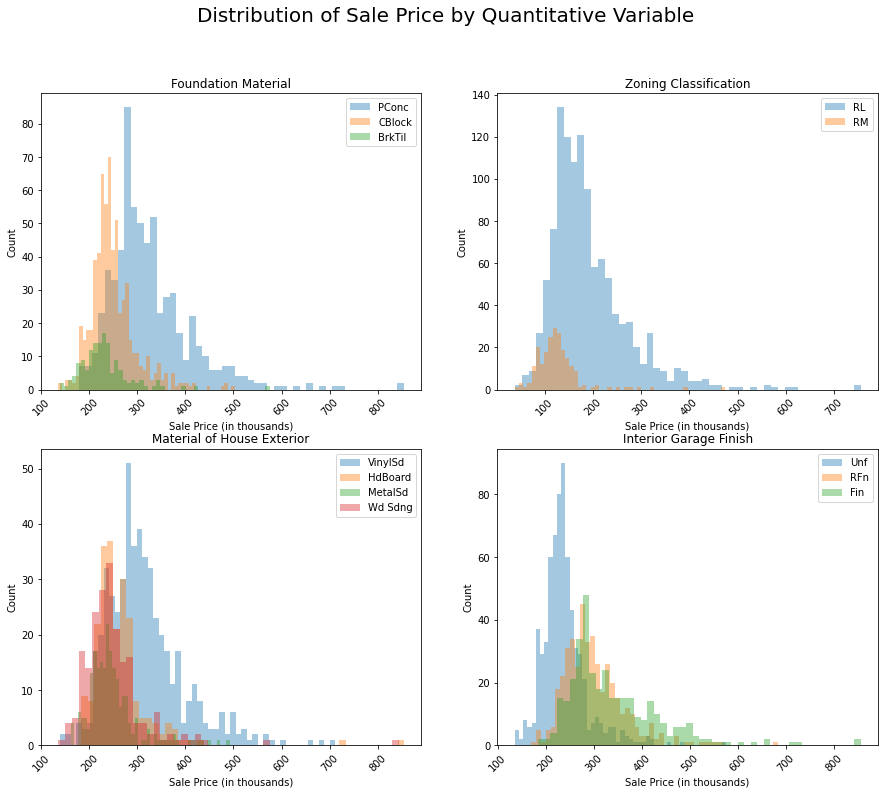

In [7]:
cols=['Foundation','MSZoning','Exterior1st','GarageFinish']
f, ax = plt.subplots(2, 2,figsize=(15,12))
f.suptitle('Distribution of Sale Price by Quantitative Variable',fontsize=20)
titles=['Foundation Material','Zoning Classification', 
        'Material of House Exterior','Interior Garage Finish']
r=c=0
i=0
for col in cols:
    for val in df[col].value_counts().index:
        if df[col].value_counts()[val]>=.1*df.shape[0]:
            ax[r][c].set_title(titles[i])
            ax[r][c].set_xlabel("Sale Price (in thousands)")
            ax[r][c].set_ylabel("Count")
            ax[r][c].set_xticklabels([i*100 for i in range(0,9)],rotation='45')
            ax[r][c].hist(df[df[col]==val]["SalePrice"],alpha=.4, label=val,bins=50)
    ax[r][c].legend(loc=1)
    i+=1
    c+=1
    if c==2:
        r+=1
        c=0

<p style="font-size:20px">Summary</p>
</br>
<p>This analysis was very insightful. I learned that the distribution of home prices was skewed which helped me focus on homes that are more typical in this market. I learned about the relationship of the size and age of a home with its price. Finally, I learned how things like the foundation material can impact home price. These insights will influence my approach to feature engineering and modelling.</p>